In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

[*********************100%***********************]  1 of 1 completed


Text(0, 0.5, 'price in USD')

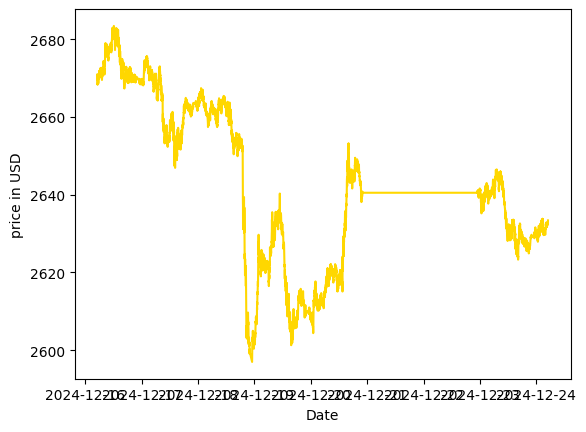

In [288]:
gold_ticker = 'GC=F'
gold_data = yf.download(gold_ticker, start='2024-12-16', end='2024-12-24', interval= '1m')
plt.plot(gold_data['Adj Close'], label = 'gold_price', color = 'gold')
plt.xlabel('Date')
plt.ylabel('price in USD')

In [289]:
gold_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F,GC=F
Datetime,,,,,,
2024-12-16 05:00:00+00:00,2670.500000,2670.500000,2670.600098,2670.199951,2670.300049,0
2024-12-16 05:01:00+00:00,2670.300049,2670.300049,2670.399902,2670.000000,2670.399902,28
2024-12-16 05:02:00+00:00,2670.399902,2670.399902,2670.600098,2670.199951,2670.300049,16
2024-12-16 05:03:00+00:00,2670.100098,2670.100098,2670.699951,2670.100098,2670.500000,35
2024-12-16 05:04:00+00:00,2670.500000,2670.500000,2670.600098,2670.300049,2670.300049,14


In [292]:
import pandas as pd

# Assuming gold_data is already loaded with Yahoo Finance data
time_series = gold_data[['Adj Close']].copy().dropna()

# Reset the index to convert the datetime index into a regular column
time_series.reset_index(inplace=True)

# Extract year, month, day, and day of the week (still relevant)
time_series['Year'] = time_series['Datetime'].dt.year
time_series['Month'] = time_series['Datetime'].dt.month
time_series['Day'] = time_series['Datetime'].dt.day
time_series['DayOfWeek'] = time_series['Datetime'].dt.dayofweek
time_series['Hour'] = time_series['Datetime'].dt.hour
time_series['Minute'] = time_series['Datetime'].dt.minute

# Calculate moving averages with a smaller window for minute-level data
time_series['MA_5'] = time_series['Adj Close'].rolling(window=5).mean()  # 5-minute moving average
time_series['MA_30'] = time_series['Adj Close'].rolling(window=30).mean()  # 30-minute moving average
time_series['Std_30'] = time_series['Adj Close'].rolling(window=30).std()  # 30-minute rolling standard deviation

# Generate lag features for the past 1 to 15 minutes
for lag in range(1, 16):  # Lags of the past 15 minutes
    time_series[f'Lag_{lag}'] = time_series['Adj Close'].shift(lag)

# Calculate the expanding mean as a proxy for the trend (this could still be relevant)
time_series['Trend'] = time_series['Adj Close'].expanding().mean()

# Flatten the MultiIndex to make column names simpler
time_series.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in time_series.columns]

# Check the column names after flattening
print(time_series.columns)

# Drop rows with NaNs in the 'Adj Close' column
time_series = time_series.dropna(subset=['Adj Close_GC=F'])

# Display the updated time series
print(time_series.head())




Index(['Datetime_', 'Adj Close_GC=F', 'Year_', 'Month_', 'Day_', 'DayOfWeek_',
       'Hour_', 'Minute_', 'MA_5_', 'MA_30_', 'Std_30_', 'Lag_1_', 'Lag_2_',
       'Lag_3_', 'Lag_4_', 'Lag_5_', 'Lag_6_', 'Lag_7_', 'Lag_8_', 'Lag_9_',
       'Lag_10_', 'Lag_11_', 'Lag_12_', 'Lag_13_', 'Lag_14_', 'Lag_15_',
       'Trend_'],
      dtype='object')
                  Datetime_  Adj Close_GC=F  Year_  Month_  Day_  DayOfWeek_  \
0 2024-12-16 05:00:00+00:00     2670.500000   2024      12    16           0   
1 2024-12-16 05:01:00+00:00     2670.300049   2024      12    16           0   
2 2024-12-16 05:02:00+00:00     2670.399902   2024      12    16           0   
3 2024-12-16 05:03:00+00:00     2670.100098   2024      12    16           0   
4 2024-12-16 05:04:00+00:00     2670.500000   2024      12    16           0   

   Hour_  Minute_       MA_5_  MA_30_  ...  Lag_7_  Lag_8_  Lag_9_  Lag_10_  \
0      5        0         NaN     NaN  ...     NaN     NaN     NaN      NaN   
1      5       

In [293]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [317]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Flatten MultiIndex columns
time_series.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in time_series.columns]

# Sort the data based on the index to ensure chronological order
time_series = time_series.sort_index()

# Features and target
X = time_series.drop(['Datetime_', 'Adj Close_GC=F'], axis=1)  # Drop datetime and target columns
y = time_series['Adj Close_GC=F']  # Target column (adjusted close price)

# Scale features and target using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# Check the shapes to verify
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')
# Check for NaNs in the training and test data
train_nan_mask = np.isnan(X_train).any(axis=1) | np.isnan(y_train).reshape(-1)
test_nan_mask = np.isnan(X_test).any(axis=1) | np.isnan(y_test).reshape(-1)

# Filter out rows with NaNs
X_train = X_train[~train_nan_mask]
y_train = y_train[~train_nan_mask]
X_test = X_test[~test_nan_mask]
y_test = y_test[~test_nan_mask]


X_train shape: (6568, 25), y_train shape: (6568, 1)
X_test shape: (1642, 25), y_test shape: (1642, 1)


In [318]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# Create data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

In [319]:
y_test_tensor[:10]

tensor([[[0.4769]],

        [[0.4757]],

        [[0.4734]],

        [[0.4803]],

        [[0.4815]],

        [[0.4826]],

        [[0.4815]],

        [[0.4745]],

        [[0.4699]],

        [[0.4572]]])

In [320]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [321]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.input_dim = input_dim  # Store input_dim as an attribute

        # LSTM and fully connected layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, bidirectional=True, dropout=0.2)
        self.fc = nn.Linear(2 * hidden_dim, output_dim)  # 2 * hidden_dim for bidirectional LSTM

    def forward(self, x):
        # Reshape the input to have a sequence length of 1
        x = x.unsqueeze(1)  # Shape becomes [batch_size, 1, input_dim]

        # Now the input has the expected shape [batch_size, seq_len, input_dim]
        batch_size, seq_len, _ = x.size()

        # Initialize hidden and cell states
        h0 = torch.zeros(2 * self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(2 * self.num_layers, batch_size, self.hidden_dim).to(x.device)

        # LSTM layer
        out, _ = self.lstm(x, (h0, c0))

        # Fully connected layer
        out = self.fc(out[:, -1, :])  # Use the last timestep
        return out

In [358]:
input_dim = X_train.shape[1]  # Number of features
hidden_dim = 64               # Number of LSTM units
num_layers = 2                # Number of LSTM layers
output_dim = 1                # Predicting one value (Close price)
# learning_rate = 0.001
epochs = 20

model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim).to(device)

In [363]:
optimizer = optim.Adam(model.parameters(), lr = 0.0002)
criterion = nn.MSELoss()

In [367]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (data_batch, target_batch) in enumerate(train_loader):
        data_batch, target_batch = data_batch.to(device), target_batch.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Squeeze target to match the model output shape
        target_batch = target_batch.squeeze(-1)  # Remove the extra dimension

        # Forward pass
        output = model(data_batch)

        # Calculate loss
        loss = criterion(output, target_batch)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/20], Loss: 0.0008
Epoch [2/20], Loss: 0.0008
Epoch [3/20], Loss: 0.0008
Epoch [4/20], Loss: 0.0008
Epoch [5/20], Loss: 0.0008
Epoch [6/20], Loss: 0.0008
Epoch [7/20], Loss: 0.0008
Epoch [8/20], Loss: 0.0008
Epoch [9/20], Loss: 0.0008
Epoch [10/20], Loss: 0.0008
Epoch [11/20], Loss: 0.0008
Epoch [12/20], Loss: 0.0007
Epoch [13/20], Loss: 0.0008
Epoch [14/20], Loss: 0.0007
Epoch [15/20], Loss: 0.0007
Epoch [16/20], Loss: 0.0007
Epoch [17/20], Loss: 0.0007
Epoch [18/20], Loss: 0.0007
Epoch [19/20], Loss: 0.0007
Epoch [20/20], Loss: 0.0007


In [368]:
model.eval()  # Set model to evaluation mode
test_loss = 0.0
predictions = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Remove extra singleton dimension from target
        y_batch = y_batch.squeeze(-1)  # Removes the last dimension if its size is 1

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

        predictions.append(outputs.cpu().numpy())

    # Calculate average test loss
    test_loss /= len(test_loader)

print(f'Test Loss: {test_loss:.4f}')


Test Loss: 0.0005


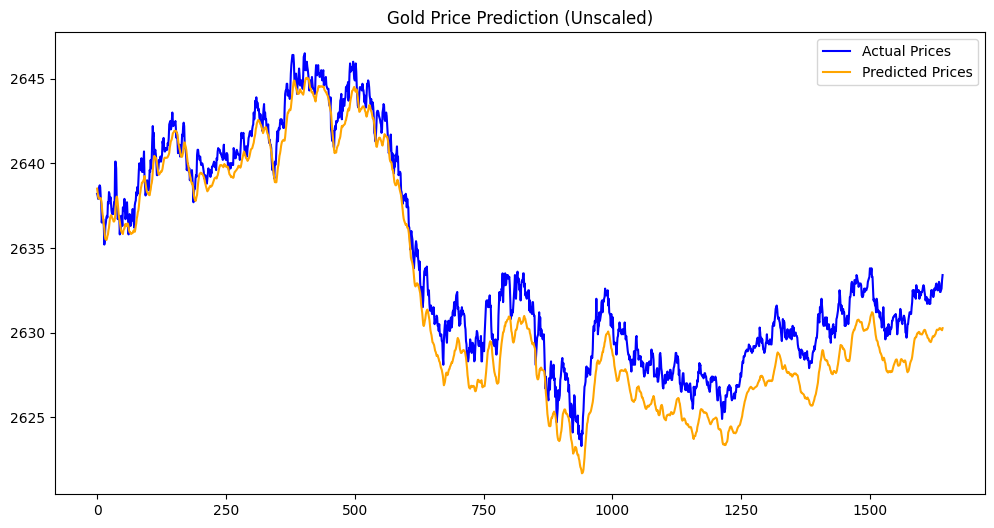

In [369]:
import numpy as np
import matplotlib.pyplot as plt

# Inverse scale the target values (y_test and predictions)
y_test_unscaled = scaler.inverse_transform(y_test)  # Reverse scaling of the test set
predictions = np.concatenate(predictions, axis=0)

predictions_unscaled = scaler.inverse_transform(predictions.reshape(-1, 1))  # Reverse scaling of predictions

# Plot actual vs. predicted values (unscaled)
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label='Actual Prices', color='blue')
plt.plot(predictions_unscaled, label='Predicted Prices', color='orange')
plt.legend()
plt.title('Gold Price Prediction (Unscaled)')
plt.show()
